### Metric methods for a regression problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy import stats
from collections import OrderedDict
%matplotlib inline

### Visualisation methods

In [2]:
def visualize(X,Y,X_test,Y_test,Y_pred=[]):
    plt.figure(figsize=(20,10))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if type(Y_pred)==np.ndarray:
        plt.plot(X_test,Y_pred,'#222222',label = 'regression line')
    
    plt.legend()
    plt.show()

In [3]:
def visualize_classes(train,test,pred_labels,figsize=(15,10),data=None,demo=False):
    plt.figure(figsize=figsize)
    
    if data is not None:
        train = data
    
    c = len(np.unique(train[:,-1]))
    colormap = plt.cm.binary_r
    colors =[x/(2*c) for x in range(2*c)]
    
    train_map = [colors[i] for i in train[:,-1].astype(int)]
    
    if data is None:
        test_map = [colors[i+c] for i in test[:,-1].astype(int)]
        pred_map = [colors[i+c] for i in pred_labels[:]]

    plt.scatter(train[:,0],train[:,1],c = train_map,cmap=plt.cm.copper,s=50,marker='o')
    if demo:
        plt.scatter(test[:,0],test[:,1],c = test_map,cmap=plt.cm.copper,s=50,marker='o')
    elif data is None:
        plt.scatter(test[:,0],test[:,1],c = pred_map,cmap=plt.cm.flag_r,s=120,marker='o')
        plt.plot([],marker='o',ms=10,ls="",color="b",label="Train")
        plt.plot([],marker='o',ms=16,ls="",color="b",label="Pred")
        plt.legend()

    plt.title('Data split by classes')
    plt.axis([-8,6,-6,3]) 
    plt.show()

Data from csv file

In [64]:
X[:,:2]

array([[ 2.946,  0.674],
       [ 3.347, -1.3  ],
       [ 4.519,  0.99 ],
       ...,
       [-4.551, -4.602],
       [-5.144, -1.847],
       [-4.348, -3.571]])

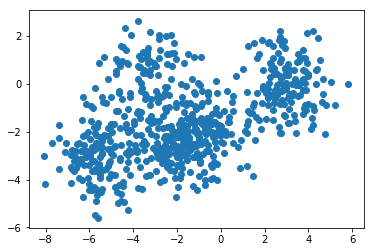

In [123]:
X = np.genfromtxt('data.csv',delimiter=',')
plt.scatter(X[:,0],X[:,1])

#train,test = train_test_split(X)
#X_tr,Y_tr = train[:,:3],train[:,3]
#X_t,Y_t = test[:,:3],test[:,3]

train, test = train_test_split(X[:,:2])
X_tr, X_t = train[:,0], test[:,0] 
Y_tr, Y_t = train[:,1], test[:,1]

### Naive approach - KNN for regression

KNN and Parzen windows for a regression problem with inverted average weights as a prediction function

In [103]:
class KNN_regression(object):
    """
    KNN for regression
    
    Arguments:
    ---------
    k -- number of nearest neighbours
    X -- input matrix
    """
    def euclidean_dist(self,x,y):
        """
        Euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return (((y-x)**2)**0.5)
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    def manhattan_dist(self,x,y):
        """
        Manhattan distance between points x and y
        """
        if type(x)==np.float64:
            return (abs(x-y))
        return sum(abs(x[i]-y[i]) for i in range(len(x)))
        
    def split_data(self):
        train,test = train_test_split(self.X)
        self.X_train,self.X_test = train[:,0],test[:,0]
        self.Y_train,self.Y_test = test[:,1],test[:,1]

    
    def __init__(self,k=None,X = None, X_train=None, X_test = None, Y_train = None, Y_test = None, window_width = None):
        if X is None:
            self.X_train, self.X_test  = X_train, X_test
            self.Y_train, self.Y_test  = Y_train, Y_test
        else:
            self.X = X
            self.split_data()
        
        if k is not None:
            self.k = k
            self.parzen = False
        else:#using Parzen window  
            self.w = window_width
            self.parzen = True
      
    def predict_average(self, distances):
        return np.mean(distances)
    
    def predict_weighted_average(self,neighbours,weights):
        """
        Arguments:
            neighbours -- list of k closest neighbours [[distance,index],...]
            weights -- list of inversed weights
        Returns:
            prediction based on weighted average
        """
        indices = [row[1] for row in neighbours]
        values = self.X_train[indices]
        
        return np.dot(values,weights)
        
    def get_Neighbours(self,point):
        """
        Arguments:
            point -- chosen point from X_test
        Returns:
            list of k closest neighbours [[distance,index],...]
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        if self.parzen:
            i = sum(1 if d<=self.w else 0 for d in list(distances.values()))
            return list(distances.items())[:i]
        else:
            k_nearest = list(distances.items())[:self.k]
            return k_nearest
        #return [row[0] for row in k_nearest]
        
    def get_Neighbours_Parzen(self,point):
        """
        Arguments:
        ----------
        point -- chosen point from X_test
        Returns:
        list of points inside a Parzen window
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        
        i = sum(1 if d<=self.w else 0 for d in list(distances.values()))
        return list(distances.items())[:i]

    def get_Weights(self,neighbours):
        """
        Arguments:
        ---------
        neighbours -- list of k closest neighbours [[distance,index],...]
        Returns:
        ---------
        list of inversed weights - highest score for the closest point
        """
        distances = [row[0] for row in neighbours]
        inversed_distances = [sum(distances)/(d+1) for d in distances]
        return [d/sum(inversed_distances) for d in inversed_distances]
    
    def predict(self):
        prediction = []
        for point in self.X_test:
            #get neighbours
            neighbours = self.get_Neighbours(point)
            #calculate weight based on proximity of each point
            weights = self.get_Weights(neighbours)
            #predict price based on their values
            prediction.append(self.predict_weighted_average(neighbours,weights))
        self.pred = np.array(prediction)
        return self.pred
    
    def calculate_error(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.X_test,self.pred)
        else:
            return mean_absolute_error(self.X_test,self.pred)
    
    
    def set_width(self, w):
        self.w = w
    
    def set_k(self,k):
        self.k = k
        
    def get_X_test(self):
        return self.X_test
    def get_pred(self):
        return self.pred

### Generating weights:

Let's say we have 3 neighbours for a certain point P.
$$totalDistance = \sum\limits_{i=0}^n{dist_i}$$

| dist(p,p1) | dist(p,p2) | dist(p,p3) | totalDistance|
| --- | --- | --- | --- |
| 0.5 | 1.5 | 4.0 | 6.0 |

Let's say we want to assign average weights based on their 'share in a total distance':

| w1 | w2 | w3 | $\sum$|
| --- | --- | --- | --- |
| 0.083 | 0.25 | 0.667 | 1.0 |

As we may see, the furthest point has the most weight.
But our goal is to make closest points the most important.
To achieve that we will use inversed average weighting

<center>Let's calculate inverted weights: <font size=4>$ w_i = \frac{totalDistance}{dist(p,p_i)+1}$</font></center>

| id1 | id2 | id3 | $\sum$|
| --- | --- | --- | ---|
| 4.0 | 2.4 | 1.2 | 7.6|

The new shares will be:

| iw1 | iw2 | iw3 | $\sum$ |
| --- | --- | --- | --- |
| 0.526 | 0.316 | 0.158 | 1.0 |


In [104]:
#nbrs = model.get_Neighbours(X_t[15])
#whts = model.get_Weights(nbrs)
#indices = [row[1] for row in nbrs]
#m = X_tr[indices][:,2]
#np.dot(m,whts)


model = KNN_regression(40,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
pr = model.predict()

print(model.calculate_error("squared"))
print(model.calculate_error("absolute"))

0.021245829275803728
0.06856857655673997


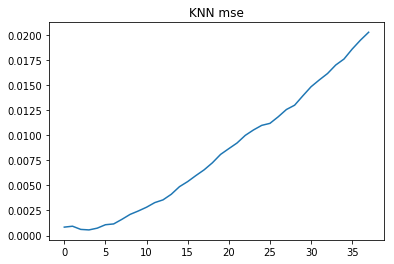

In [105]:
accuracy = []
model = KNN_regression(1,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
for i in range(2,40):
    model.set_k(i)
    pr = model.predict()
    accuracy.append(model.calculate_error())
plt.title("KNN mse")
plt.plot(accuracy)

In [106]:
model = KNN_regression(X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test = Y_t, window_width=36.0)
pr = model.predict()

model.calculate_error()

0.01856754535169097

### Kernel Regression

<font size=5>$ f(x):= \frac {\sum_{i=1}^n K_{\lambda}(x_0,x_i)y_i}{\sum_{i=1}^n K_{\lambda}(x_0,x_i)} $</font>

In [116]:
class Kernel:
    """
    Nadaraya-Watson weighted average regressor using kernel functions
    """
    def __init__(self,X_train,Y_train,X_test,Y_test, params, lam = 0.2):
        
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.lam = lam
        if params:
            self.params = params
        else:
            print("wrong set of parameters")
    
    def kernel(self,x0,x1):
        """
        Arguments:
        ----------
        x0 -- test point
        x1 -- train point
        Returns:
        -------
        value of Kernel function for a specific pair and parameter
        """
        u = abs(x0-x1)/self.lam
       # print(u,x0,x1)
        if abs(u)<=1:
            return 0
        else:
            if self.current_param == "parabolic": #Epanenchikov
                return 0.75 * (1-u**2)
            
            elif self.current_param == "quartic":#Біквадратне
                return 15*((1-u**2)**2)/16

            elif self.current_param == "gaussian":
                return np.exp(-0.5 * u**2) / ((2 * np.pi)**0.5)
        
            elif self.current_param == "cosine":#Косинусоидальное
                return np.pi/4 * np.cos(u*np.pi/2)
            
            elif self.current_param == "triangle":
                return 1-abs(u)
            
            elif self.current_param == "uniform":
                return 0.5
        
            return 0.5  
        
    def predict(self,param):
        
        if param.lower() in self.params:
            self.current_param = param
        else:
            self.current_param = param[0].lower()
        
        prediction = []
        for point in self.X_test:
            K =[self.kernel(x,point) for x in self.X_train]#values of a kernel function
            prediction.append(sum(k*y for k,y in zip(K,self.Y_train))/sum(K))                      
        self.pred = prediction
        return self.pred
        
    
    def calculate_accuracy(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.X_test,self.pred)
        else:
            return mean_absolute_error(self.X_test,self.pred)

In [117]:
parameters = ["parabolic","quartic","gaussian"]
k = Kernel(X_tr,Y_tr,X_t,Y_t,parameters)
p = k.predict("quartic")

In [113]:
k.calculate_accuracy()

16.309728703754907

### LOWESS algorithm

In [22]:
#draft

In [ ]:
class LOWESS:
    """
    
    """
    
    def __init__(self,X_train,Y_train,X_test,Y_test):
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
    def fit(self, X,Y):
    
    
    def kernel(self):
    
    def predict(self,X_test = None):
    
    
    def calculate_accuracy(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.X_test[:,2],self.pred)
        else:
            return mean_absolute_error(self.X_test[:,2],self.pred)
